In [1]:


import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from numpy import sqrt

In [2]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1.900052e+09,2019-06-04,ZB00025746,1,9.412096,0.000000,9.412096,0.000000,9.412096,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1.900101e+09,2019-07-15,ZB00025746,1,8.648837,5.393411,8.648837,5.393411,3.255426,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1.900107e+09,2019-07-24,ZB00025746,1,8.648837,5.458527,8.648837,5.458527,3.190310,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1.900111e+09,2019-08-01,ZB00025746,1,8.648837,5.440310,8.648837,5.440310,3.208527,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1.900052e+09,2019-06-04,ZB00022010,1,12.784729,4.087597,12.784729,4.087597,8.697132,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [5]:
def select_series(data, time_period='week', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [6]:
weekly_sales=select_series(data)
weekly_sales.columns=['ds', 'y']
weekly_sales.ds=pd.to_datetime(weekly_sales['ds'])
weekly_sales.sort_values('ds')
weekly_sales.head()

,ds,y
0,2019-06-02,31197.925662
1,2019-06-09,218374.722548
2,2019-06-16,138748.856953
3,2019-06-23,263338.411548
4,2019-06-30,149753.706266


In [7]:
weekly_sales.shape

(102, 2)

In [8]:
#daily_sales['y']=np.log(daily_sales['y'])

In [9]:

train_df=weekly_sales[:int(weekly_sales.shape[0]*0.75)]

test_df=weekly_sales[int(weekly_sales.shape[0]*0.75):]
print(train_df.shape)
print(test_df.shape)

(76, 2)
(26, 2)


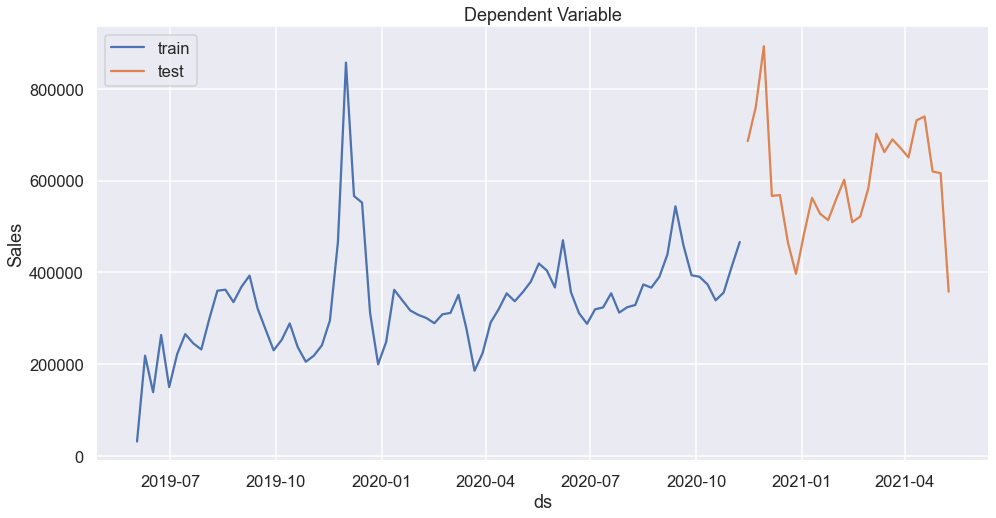

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)

ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');

In [11]:
#training the model on training set
from prophet.plot import add_changepoints_to_plot

model=Prophet(growth='linear',weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.001)
model.add_seasonality( name='monthly', period=30.5, fourier_order=5)
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [12]:
future=model.make_future_dataframe(periods=test_df.shape[0]+5, freq='W')
forecast=model.predict(future)

In [13]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-02,250863.087837,181276.241923,400246.965649,250863.087837,250863.087837,40396.233215,40396.233215,40396.233215,40396.233215,40396.233215,40396.233215,0.0,0.0,0.0,291259.321052
1,2019-06-09,252948.212674,179562.004480,398837.570094,252948.212674,252948.212674,37630.493600,37630.493600,37630.493600,37630.493600,37630.493600,37630.493600,0.0,0.0,0.0,290578.706274
2,2019-06-16,255033.337512,148223.802595,371415.698118,255033.337512,255033.337512,9097.121181,9097.121181,9097.121181,9097.121181,9097.121181,9097.121181,0.0,0.0,0.0,264130.458693
3,2019-06-23,257118.462349,134417.548785,360607.304324,257118.462349,257118.462349,-9446.864811,-9446.864811,-9446.864811,-9446.864811,-9446.864811,-9446.864811,0.0,0.0,0.0,247671.597538
4,2019-06-30,259203.587186,141094.947979,362488.575173,259203.587186,259203.587186,-4543.987004,-4543.987004,-4543.987004,-4543.987004,-4543.987004,-4543.987004,0.0,0.0,0.0,254659.600182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2021-05-16,463545.821247,393945.327961,621064.963828,463545.812264,463545.830180,47236.038799,47236.038799,47236.038799,47236.038799,47236.038799,47236.038799,0.0,0.0,0.0,510781.860046
103,2021-05-23,465630.946084,319718.936703,549487.059065,465630.936561,465630.955545,-37868.832251,-37868.832251,-37868.832251,-37868.832251,-37868.832251,-37868.832251,0.0,0.0,0.0,427762.113833
104,2021-05-30,467716.070922,260563.871698,484955.754371,467716.060856,467716.080928,-93068.957209,-93068.957209,-93068.957209,-93068.957209,-93068.957209,-93068.957209,0.0,0.0,0.0,374647.113712
105,2021-06-06,469801.195759,306503.833146,521616.406275,469801.184990,469801.206223,-55703.281121,-55703.281121,-55703.281121,-55703.281121,-55703.281121,-55703.281121,0.0,0.0,0.0,414097.914638


In [14]:
# We want to look at yhat, yhat_lower, and yhat_upper only. 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-02,291259.321052,181276.241923,400246.965649
1,2019-06-09,290578.706274,179562.004480,398837.570094
2,2019-06-16,264130.458693,148223.802595,371415.698118
3,2019-06-23,247671.597538,134417.548785,360607.304324
4,2019-06-30,254659.600182,141094.947979,362488.575173


In [15]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
102,2021-05-16,463545.821247,393945.327961,621064.963828,463545.812264,463545.830180,47236.038799,47236.038799,47236.038799,47236.038799,47236.038799,47236.038799,0.0,0.0,0.0,510781.860046
103,2021-05-23,465630.946084,319718.936703,549487.059065,465630.936561,465630.955545,-37868.832251,-37868.832251,-37868.832251,-37868.832251,-37868.832251,-37868.832251,0.0,0.0,0.0,427762.113833
104,2021-05-30,467716.070922,260563.871698,484955.754371,467716.060856,467716.080928,-93068.957209,-93068.957209,-93068.957209,-93068.957209,-93068.957209,-93068.957209,0.0,0.0,0.0,374647.113712
105,2021-06-06,469801.195759,306503.833146,521616.406275,469801.184990,469801.206223,-55703.281121,-55703.281121,-55703.281121,-55703.281121,-55703.281121,-55703.281121,0.0,0.0,0.0,414097.914638
106,2021-06-13,471886.320596,360868.754465,581891.577414,471886.309147,471886.331697,-767.923046,-767.923046,-767.923046,-767.923046,-767.923046,-767.923046,0.0,0.0,0.0,471118.397550


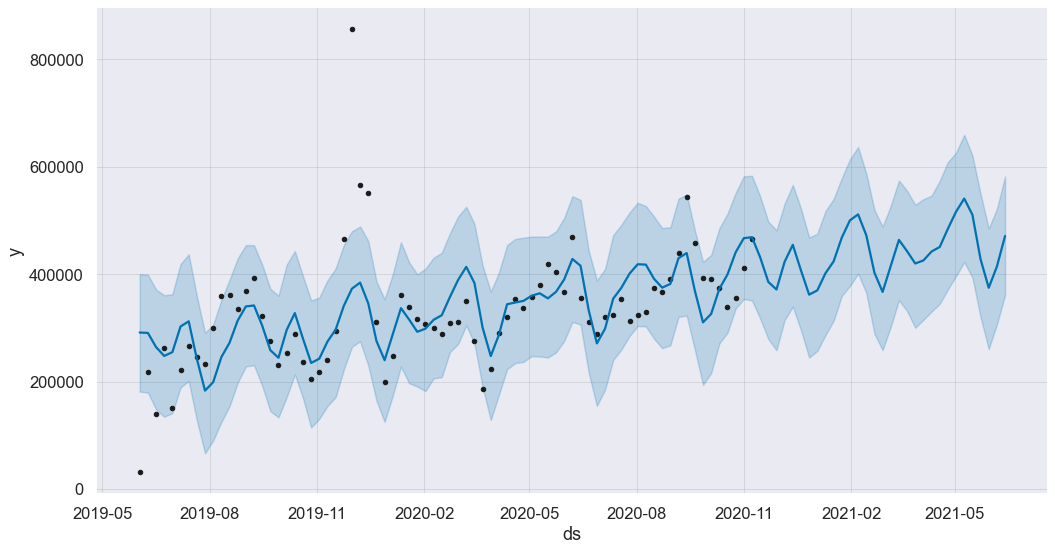

In [16]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

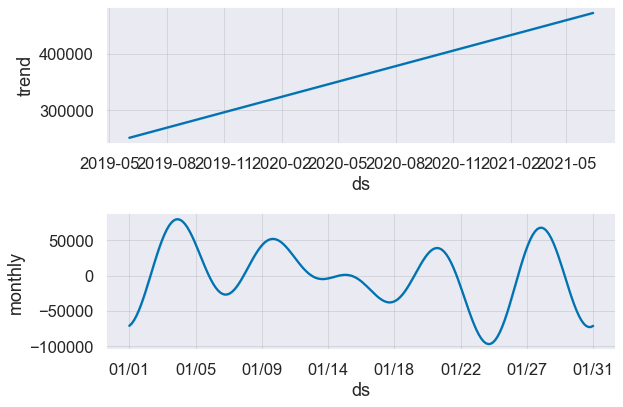

In [17]:
# ploting model components
model.plot_components(forecast)

plt.show()

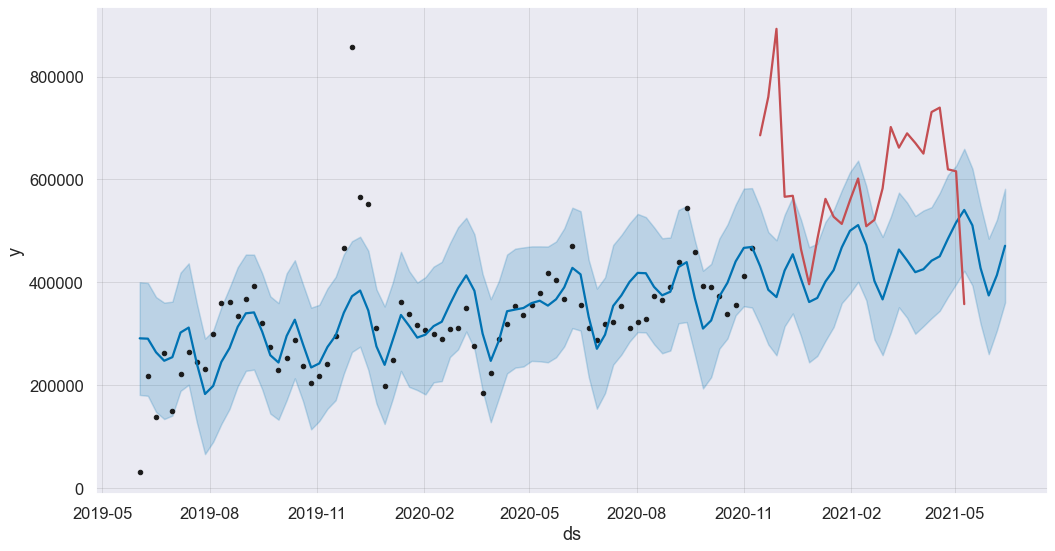

In [18]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r')



In [19]:
x_test_forecast=model.predict(test_df)
x_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
19,2021-03-28,419831.166708,301893.723170,525102.427152
20,2021-04-04,425615.517163,308917.894908,539389.149442
21,2021-04-11,442137.913679,317431.370685,554589.620714
22,2021-04-18,450660.965610,340899.436480,562703.233593
23,2021-04-25,484686.098229,368255.395114,603686.081516
24,2021-05-02,516357.525595,394215.214055,630553.081864
25,2021-05-09,540786.433809,422137.445643,661604.467202


Text(0.5, 1.0, 'Forecast VS Actual')

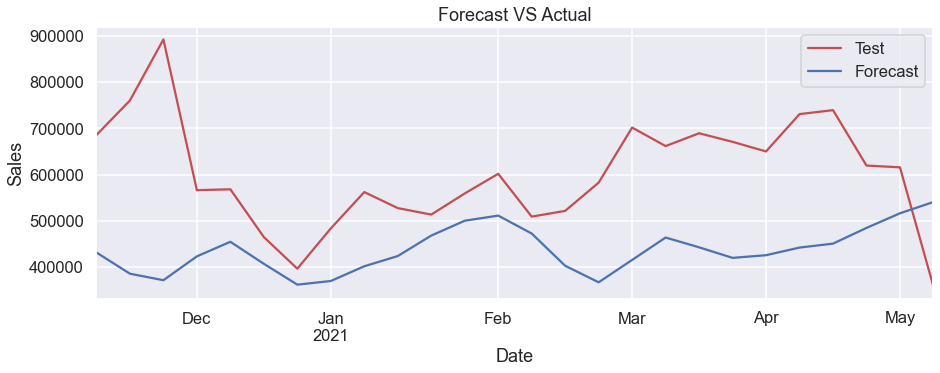

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual')



Text(0.5, 1.0, 'One month Forecast Vs Actual, April 07 to May 6 , 2021')

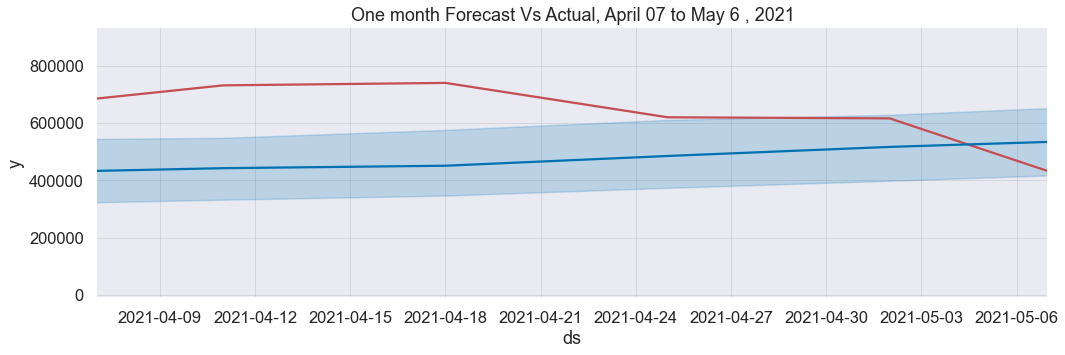

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

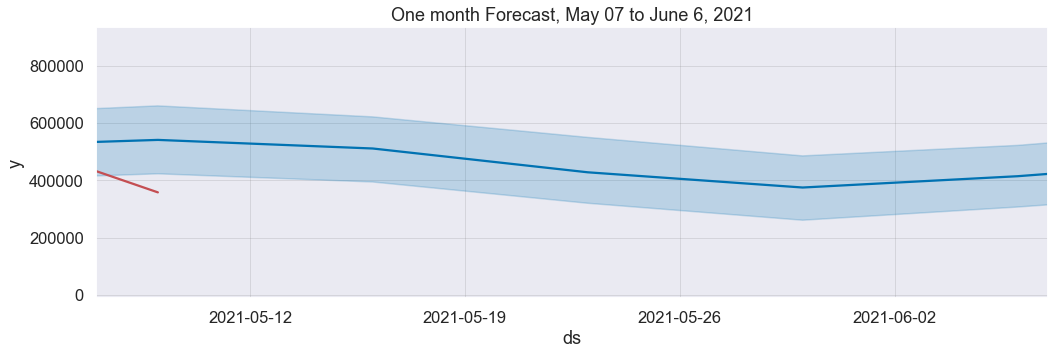

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

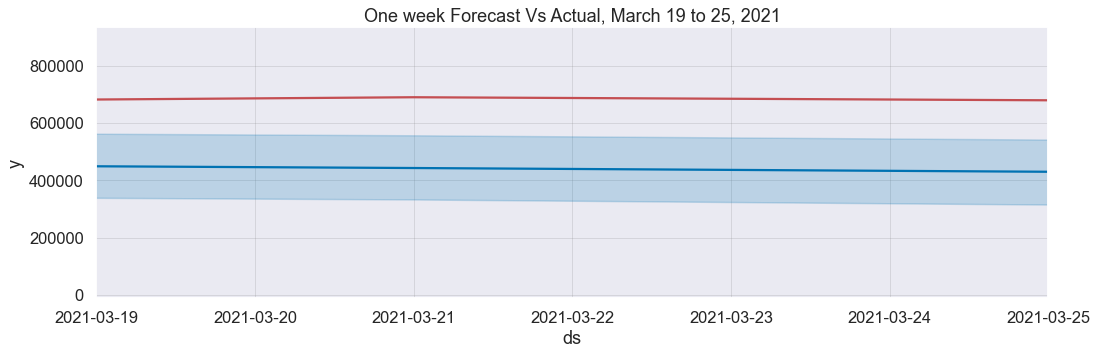

In [23]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')


In [24]:
# Means Squared Error and RSME
predictions=forecast.yhat[-26:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model=model, horizon='35 days', initial='350', period='56 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-07-14 00:00:00 and 2020-10-04 00:00:00


MSE:  43992480874.06937
RMSE:  209743.8458550557


INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



MAPE:  122.12372081763661


In [25]:
df_cv.head(20)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-21,2.823279e+06,2.823279e+06,2.823279e+06,245142.608505,2019-07-14
1,2019-07-28,1.436251e+06,1.436251e+06,1.436251e+06,231863.308085,2019-07-14
2,2019-08-04,3.856185e+06,3.856185e+06,3.856185e+06,298946.574148,2019-07-14
3,2019-08-11,3.266827e+06,3.266827e+06,3.266827e+06,359874.138819,2019-07-14
4,2019-08-18,2.322427e+06,2.322427e+06,2.322427e+06,362089.728975,2019-07-14
5,2019-09-15,4.227736e+05,3.910131e+05,4.497449e+05,321355.876465,2019-09-08
6,2019-09-22,5.061520e+05,4.767418e+05,5.384270e+05,275338.935930,2019-09-08
7,2019-09-29,4.288263e+05,3.988197e+05,4.590864e+05,229987.546293,2019-09-08
8,2019-10-06,4.921012e+05,4.623007e+05,5.224483e+05,252745.906166,2019-09-08
9,2019-10-13,5.211550e+05,4.923226e+05,5.494319e+05,288591.314446,2019-09-08


In [26]:
df_cv.tail(25)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
20,2020-03-01,531648.387915,398018.773508,659621.258859,311424.789419,2020-02-23
21,2020-03-08,527659.570495,399790.223396,656880.691665,350914.911741,2020-02-23
22,2020-03-15,489592.717809,358791.909809,624358.558270,276230.055864,2020-02-23
23,2020-03-22,381829.829835,246406.336919,506968.325989,185464.559102,2020-02-23
24,2020-03-29,302174.754275,191551.350057,432613.910879,223796.838266,2020-02-23
25,2020-04-26,414293.066824,293552.521540,535535.487406,336968.729436,2020-04-19
26,2020-05-03,421198.923964,301253.938642,534528.381963,356608.992538,2020-04-19
27,2020-05-10,414782.583141,300473.329547,532249.825600,379547.883007,2020-04-19
28,2020-05-17,388528.780101,274452.625531,512773.639343,419131.429309,2020-04-19
29,2020-05-24,419792.994564,296294.442619,546974.910013,403916.200534,2020-04-19


In [27]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv, rolling_window=0.1)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,7.512905e+11,8.667701e+05,371233.351405,1.466391,0.315593,0.444444
1,14 days,1.743186e+11,4.175148e+05,221817.372404,0.854450,0.305336,0.555556
2,21 days,1.418942e+12,1.191193e+06,479851.462601,1.609895,0.330910,0.555556
3,28 days,9.847072e+11,9.923242e+05,466440.778569,1.289753,0.384585,0.555556
4,35 days,4.431156e+11,6.656693e+05,318195.149804,0.885697,0.322816,0.444444


In [28]:
df_cv2=cross_validation(model, horizon='26 days', initial=750, period='56 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-07-23 00:00:00 and 2020-10-13 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



MAPE:  122.12372081763661


In [29]:
df_cv2

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-28,-555223.788214,-555223.788653,-555223.787785,231863.308085,2019-07-23
1,2019-08-04,-253959.003058,-253959.003834,-253959.002365,298946.574148,2019-07-23
2,2019-08-11,-300664.020483,-300664.022007,-300664.019218,359874.138819,2019-07-23
3,2019-08-18,-561353.639913,-561353.642198,-561353.637744,362089.728975,2019-07-23
4,2019-09-22,475474.076814,442897.573515,506970.249046,275338.935930,2019-09-17
5,2019-09-29,404247.164530,371063.059968,435045.649405,229987.546293,2019-09-17
6,2019-10-06,478602.991093,448060.254135,511346.163817,252745.906166,2019-09-17
7,2019-10-13,496579.402103,465432.532570,528986.372622,288591.314446,2019-09-17
8,2019-11-17,367869.648425,288157.550252,446555.572702,294853.478240,2019-11-12
9,2019-11-24,398878.497895,317275.289191,481629.398310,465949.468812,2019-11-12


Text(0.5, 1.0, 'Forecast Vs Actual after Cross Validation')

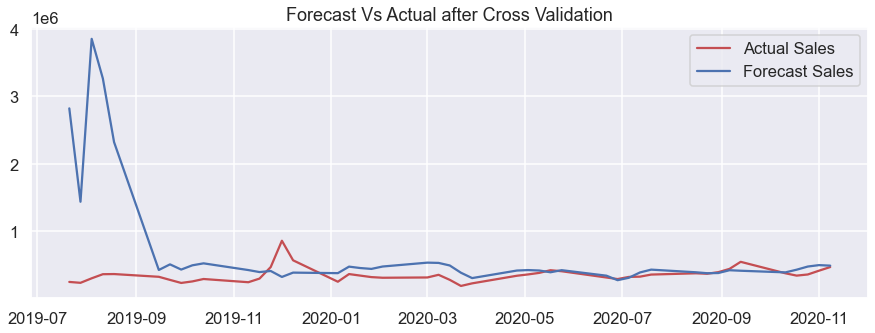

In [30]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title('Forecast Vs Actual after Cross Validation')

# Hyperparameter tuning


In [29]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffaeeb252b0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ffaf8bd7430>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

    changepoint_prior_scale  seasonality_prior_scale           rmse
0                     0.001                     0.01  124766.560250
1                     0.001                     0.10  124766.560250
2                     0.001                     1.00  124766.560250
3                     0.001                    10.00  124766.560250
4                     0.010                     0.01  109975.154349
5                     0.010                     0.10  109975.154349
6                     0.010                     1.00  109975.154349
7                     0.010                    10.00  109975.154349
8                     0.100                     0.01  109905.213543
9                     0.100                     0.10  109905.213543
10                    0.100                     1.00  109905.213543
11                    0.100                    10.00  109905.213543
12                    0.500                     0.01  104749.956135
13                    0.500                     

In [32]:
final_model=Prophet(growth='linear',weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.500)
final_model.add_seasonality( name='monthly', period=30.5, fourier_order=5)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [33]:
future=final_model.make_future_dataframe(periods=test_df.shape[0]+5, freq='W')
final_forecast=final_model.predict(future)

In [34]:
final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-02,174815.552146,78404.656515,272735.280816
1,2019-06-09,190226.845472,94016.940801,294889.530807
2,2019-06-16,177873.663505,84323.121110,282230.306095
3,2019-06-23,172246.581071,69639.494537,265698.340286
4,2019-06-30,193609.289570,97136.843986,288336.800396


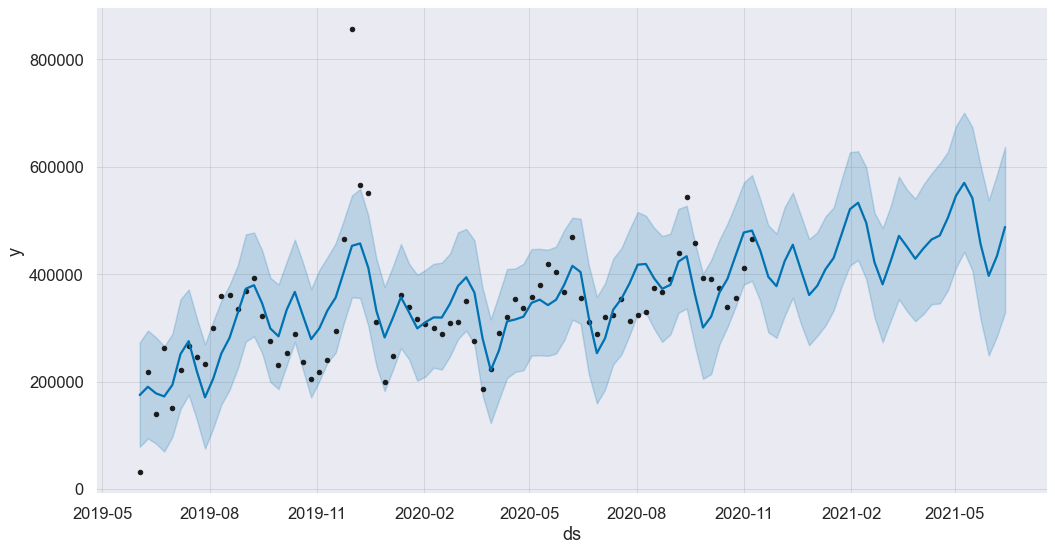

In [35]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
plt.show()

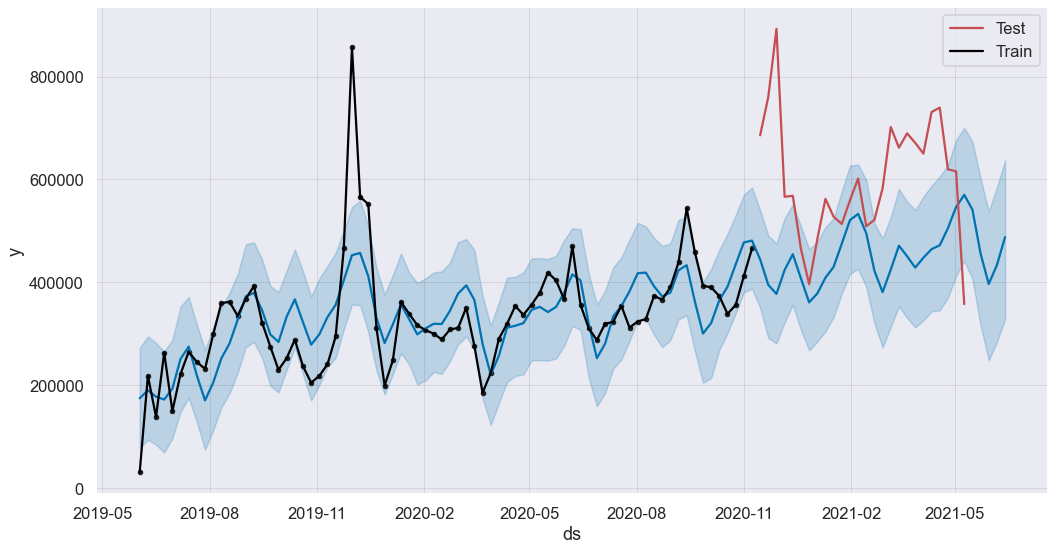

In [53]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Forecast VS Actual')

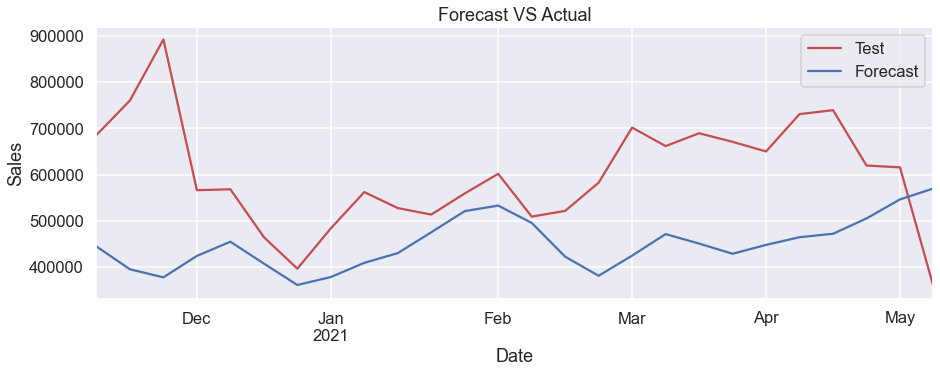

In [37]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual')

In [38]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  26.48898127164357


Text(0.5, 1.0, 'One month Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

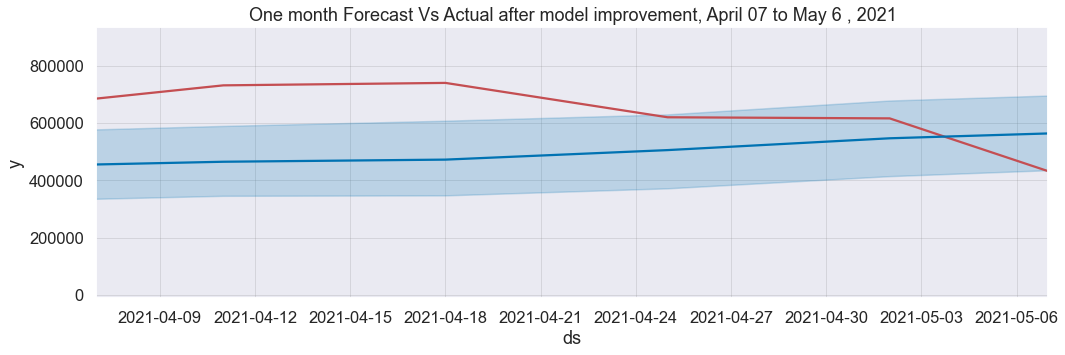

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

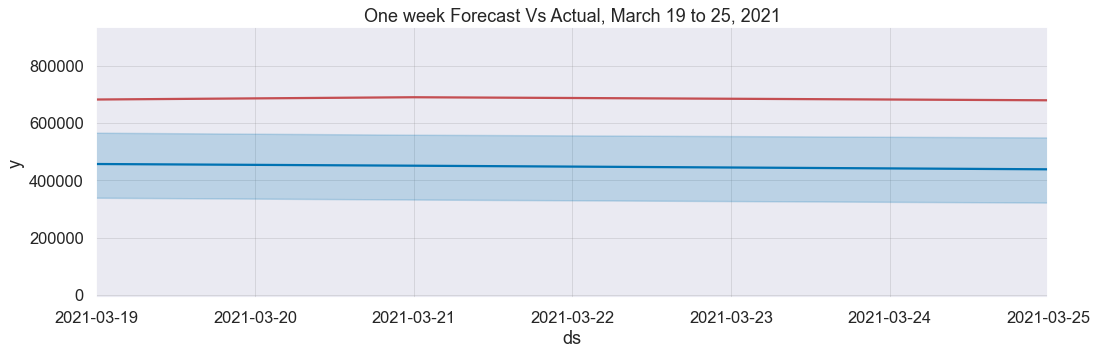

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')

Text(0.5, 1.0, 'One month Forecast, May 01 to 30, 2021')

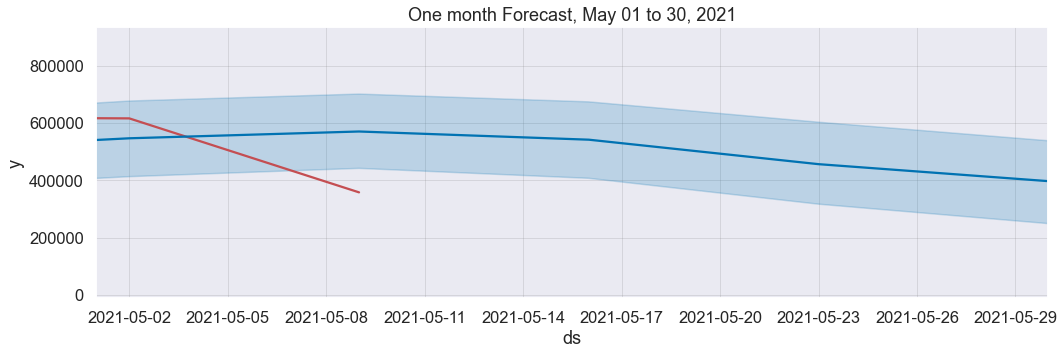

In [41]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-05-01', upper='2021-05-30')

plt.title('One month Forecast, May 01 to 30, 2021')

Text(63.75, 0.5, 'Sales')

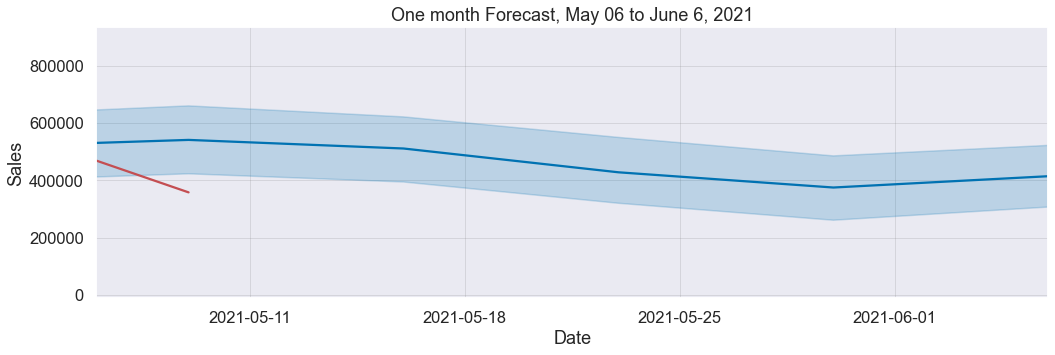

In [42]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-06', upper='2021-06-06')
plt.title('One month Forecast, May 06 to June 6, 2021')
plt.xlabel('Date')
plt.ylabel('Sales')

In [43]:
forecast_one=forecast[['ds', 'yhat']]
forecast_two=final_forecast[['ds', 'yhat']]

In [44]:
forecast_one.columns=['ds', 'yhat_one']
forecast_two.columns=['ds', 'yhat_two']

In [45]:
forecast_combined=pd.merge(forecast_one, forecast_two, on='ds')

In [46]:
forecast_combined.head()

,ds,yhat_one,yhat_two
0,2019-06-02,291259.321052,174815.552146
1,2019-06-09,290578.706274,190226.845472
2,2019-06-16,264130.458693,177873.663505
3,2019-06-23,247671.597538,172246.581071
4,2019-06-30,254659.600182,193609.289570


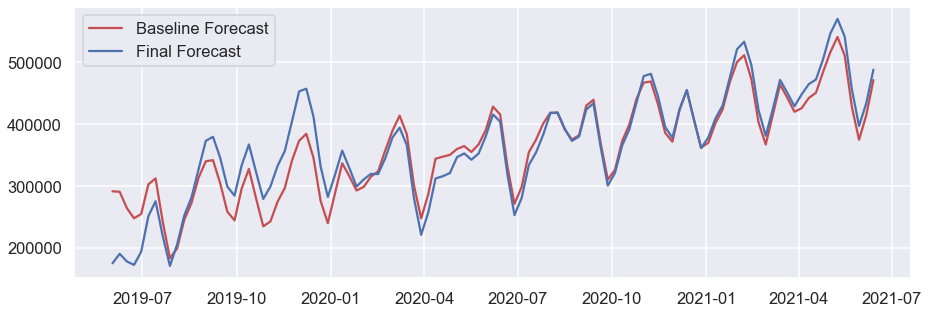

In [47]:
# Comparing the final forecast with the baseline forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(forecast_combined['ds'], forecast_combined['yhat_one'], color='r', label='Baseline Forecast')
ax.plot(forecast_combined['ds'], forecast_combined['yhat_two'], color='b', label='Final Forecast')
plt.legend()
plt.show()
